In [42]:
import pandas as pd
import numpy as np

In [89]:
data = pd.read_csv("results/identify_associations/results_sig_assoc.tsv", sep="\t")

In [149]:
data[lambda x: x.feature_a_id == 9].head(10)

,feature_a_id,feature_b_id,feature_a_name,feature_b_name,feature_b_dataset,proba,fdr,bayes_k
2,9,89,drugs_10,proteomics_90,random.small.proteomics,1.000000,1.000000e-08,18.420681
77,9,345,drugs_10,metagenomics_146,random.small.metagenomics,0.954424,2.057010e-02,-3.041717
78,9,154,drugs_10,proteomics_155,random.small.proteomics,0.953727,2.089544e-02,3.025830
79,9,1099,drugs_10,metagenomics_900,random.small.metagenomics,0.952255,2.123107e-02,-2.992950
80,9,521,drugs_10,metagenomics_322,random.small.metagenomics,0.951282,2.157041e-02,-2.971763
81,9,186,drugs_10,proteomics_187,random.small.proteomics,0.951220,2.190224e-02,2.970414
82,9,41,drugs_10,proteomics_42,random.small.proteomics,0.951087,2.222767e-02,2.967561
83,9,137,drugs_10,proteomics_138,random.small.proteomics,0.945559,2.261117e-02,2.854654
84,9,485,drugs_10,metagenomics_286,random.small.metagenomics,0.944591,2.299703e-02,2.836010


In [120]:
from pathlib import Path
import torch
import hydra
from move.data import io
from move.data.dataloaders import make_dataloader
from move.data.perturbations import perturb_categorical_data

cfg = io.read_config("random_small", "random_small__latent")

cat_list, cat_names, con_list, con_names = io.load_preprocessed_data(
    Path(cfg.data.interim_data_path),
    cfg.data.categorical_names,
    cfg.data.continuous_names,
)

baseline_dataloader = make_dataloader(
    cat_list,
    con_list,
    shuffle=False,
    batch_size=cfg.task.batch_size,
)
baseline_dataset = baseline_dataloader.dataset

dataloaders = perturb_categorical_data(
    baseline_dataloader,
    cfg.data.categorical_names,
    "random.small.drugs",
    np.array([0, 1]),
)

In [101]:
model = hydra.utils.instantiate(
    cfg.task.model,
    continuous_shapes=baseline_dataset.con_shapes,
    categorical_shapes=baseline_dataset.cat_shapes,
)
# requiere modelo entrenado
model.load_state_dict(torch.load("results/latent_space/model.pt"))
model.eval()

VAE (1240 ⇄ 1000 ⇄ 150)

In [159]:
drug_idx = 9

_, baseline_recon = model.reconstruct(baseline_dataloader)
_, perturb_recon = model.reconstruct(dataloaders[drug_idx])
diff = (perturb_recon - baseline_recon)

In [130]:
feature_mask = np.all(cat_list[0] == [0, 1], axis=2)
feature_mask |= np.sum(cat_list[0], axis=2) == 0

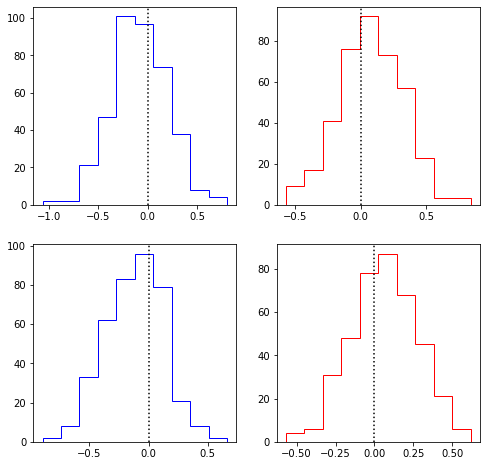

In [172]:
import matplotlib.pyplot as plt

# Mirar tabla de arriba para cambiar 'feature_idx'
# y hacer plots para ver como el signo de K mueve
# la distribución hacia la derecha/izquierda del 0
subset = data[lambda x: x.feature_a_id == drug_idx]

feature_ids = subset["feature_b_id"][:4]
signs = np.sign(subset["bayes_k"][:4])
mask = feature_mask[:, drug_idx]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for ax, feature_idx, sign in zip(axs.flatten(), feature_ids, signs):
    color = "b" if sign > 0 else "r"
    ax.hist(diff[:, feature_idx][~mask], histtype='step', color=color)
    ax.axvline(x=0, color="k", linestyle=":")

fig.savefig("pau.png")